In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

import torch
import torch.nn.functional as F
from torch import nn
from tqdm.auto import tqdm
import random
from collections import Counter
import re

In [2]:
!wget "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"

--2025-05-08 21:32:56--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.04s   

2025-05-08 21:32:56 (28.4 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [3]:
with open('/content/input.txt', mode='r', encoding='utf-8') as f:
    text = f.read()

In [4]:
print('Length of data: ', len(text))
print(text[:100])

Length of data:  1115394
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


## **Tokenizer**

**Byte Pair Encoding (BPE):** Iteratively merges the most frequent adjacent symbol pairs to reduce vocabulary size while preserving meaning.
- This is an unsupervised, data-driven tokenization algorithm often used for compressing and preprocessing input in NLP tasks.

**Note:** In it's orginal form, first we should convert all characters to their unicode format. After this we must create new index for each new pairs. Nonetheless, in this implementation I just used the orginal characters and split them using regular expresion.

In [ ]:
def merge(words, pair):
    new_words = []
    for word in words:
        pairs = [[word[i] + ' ' + word[i+1]] for i in range(len(word) - 1)]
        if pair in [''.join(pair) for pair in pairs]:
            item = ' '.join(word)
            item = item.replace(' '.join(pair.split()), ''.join(pair.split()))
            new_words.append(item.split())
        else:
            new_words.append(word)

    return new_words

def PBE(text, num_iteration=1000, freq_limit=5, pattern=r"\s*\S+"):
    # Tokenize input text into list of character lists per word
    words = [[c for c in item] for item in re.findall(pattern, text)]

    pbar = tqdm(range(num_iteration))  # Show progress bar

    for _ in pbar:
        pairs = []
        for item in words:
            # Collect all adjacent character pairs from words
            pairs += [item[i] + ' ' + item[i+1] for i in range(len(item) - 1)]

        # Find most common pair
        max = Counter(pairs).most_common(1)[0]

        if max[1] > freq_limit:
            pair = max[0]
            words = merge(words, pair)  # Merge the pair in all words
        else:
            break  # Stop if no pair is frequent enough

        pbar.set_description(f"Max frequency: {max[1]}, ")

    # Flatten the list of words into a single list of subwords/tokens
    return [w for word in words for w in word]

In [5]:
#tokens = PBE(text, num_iteration=4000)

# As I train the tokenizer in the past, I just use it
!cp "/content/drive/MyDrive/LLM/TinyShakesCustomTokens4000.npy" /content/
tokens = np.load('/content/TinyShakesCustomTokens4000.npy')

In [6]:
chars = sorted(list(set(tokens)))

for item in sorted(list(set(text))):
    if item not in chars:
        print(item, "was not in the tokens, adding...")
        chars.append(item)

q was not in the tokens, adding...


In [7]:
VOCAB_SIZE = len(chars)
T = 256 # length of text sequence
BATCH_SIZE = 64
LR = 2e-3
EPOCHS = 2000
EVAL_INTERVAL = 100
EVAL_ITER = 5
N_EMBD = 192
N_HEAD = 8
NUM_BLOCK = 16

In [8]:
stoi = {ch:i for i, ch in enumerate(chars)} # String to int
itos = {i:ch for i, ch in enumerate(chars)} # Int to string

encode = lambda s: [stoi[item] for item in s]
decode = lambda i:  ''.join(itos[c] for c in i)

In [9]:
# Set a random seed for reproducibility of results
torch.manual_seed(123)

# Choose 'cuda' if a GPU is available, otherwise fall back to CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Available device is: ', device)

# Convert the encoded text into a PyTorch tensor, store it on the selected device
data = torch.tensor(encode(text), dtype=torch.long, device=device)

# Display the shape and data type of the tensor
data.shape, data.dtype

Available device is:  cuda


(torch.Size([1115394]), torch.int64)

In [10]:
# Split the data into 90% training and 10% testing
split = int(0.9 * len(data))
train_data = data[:split]
test_data = data[split:]

# Show the lengths of the training and testing sets
len(train_data), len(test_data)

(1003854, 111540)

In [11]:
# Function to generate a batch of input (x) and target (y) sequences from the dataset
def get_batch(data_set, device, T=T):
    # Randomly select starting indices for BATCH_SIZE number of sequences
    # Ensures sequences of length T can be formed without going out of bounds
    idx = torch.randint(len(data_set) - T, (BATCH_SIZE,))

    # Stack BATCH_SIZE input sequences of length T starting from the random indices
    x = torch.stack([data_set[i: i + T] for i in idx]).to(device)

    # Stack BATCH_SIZE target sequences by shifting each input sequence by one token
    y = torch.stack([data_set[i + 1: i + T + 1] for i in idx]).to(device)

    # Return a batch of input and corresponding target sequences
    return x, y

## **Transfomer decoder architecture impelemtetion**

### **1. Single Attention Head (Head)**

First is implementing **scaled dot-product** attention with **causal masking** for autoregressive token prediction. It models how each token attends to previous tokens in the sequence.

Given a sequence of token embeddings $X \in \mathbb{R}^{B \times T \times C}$, we compute attention weights:
<br>

$$
\large \text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^\top}{\sqrt{d_k}} + \text{mask} \right)V
$$

> Query: $Q = XW^Q$ <br>
Key: $K = XW^K$ <br>
Value: $V = XW^V$ <br>
$d_k$: Dimension of keys (i.e., head size) <br>
*mask:* Causal (lower triangular) mask ensures no future tokens are attended.

In [ ]:
class Head(nn.Module):
    def __init__(self, n_embd=N_EMBD, h_s=HEAD_SIZE):
        super().__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        # Linear projections for Q, K, V (no bias for simplicity)
        self.query = nn.Linear(n_embd, h_s, bias=False)
        self.key = nn.Linear(n_embd, h_s, bias=False)
        self.value = nn.Linear(n_embd, h_s, bias=False)

        self.drop = nn.Dropout(0.2)

    def forward(self, x):
        B, T, C = x.shape  # Batch, Time, Embedding size
        q = self.query(x)  # (B, T, h_s)
        k = self.key(x)
        v = self.value(x)

        # Scaled dot-product attention
        wei = (q @ k.transpose(-1, -2)) * (C ** -0.5)

        # Apply causal mask to prevent attending to future positions
        tril = torch.tril(torch.ones(T, T)).to(self.device)
        wei = wei.masked_fill(tril == 0, float('-inf'))

        # Apply softmax + dropout
        wei = self.drop(F.softmax(wei, dim=-1))  # (B, T, T)

        # Weighted sum of value vectors
        return wei @ v  # (B, T, h_s)

### **2. Multi-head Attention (MultiHead)**
Combines multiple attention heads in parallel to allow the model to jointly attend to information from different representation subspaces at different position, which enables richer representations than a single head.

If we use $h$ heads, each head computes its own attention:
<br>

$$
\large \text{head}_i = \text{Attention}(Q_i, K_i, V_i)
$$

The outputs are concatenated and projected:
<br>

$$
\large \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \ldots, \text{head}_h)W^O
$$

In [ ]:
class MultiHead(nn.Module):
    def __init__(self, n_embd=N_EMBD, n_h=N_HEAD):
        super().__init__()
        # Create n_h attention heads
        self.multi_head = nn.ModuleList([
            Head(n_embd, n_embd // n_h) for _ in range(n_h)
        ])

        # Output projection layer to mix heads
        self.proj = nn.Linear(n_embd, n_embd)
        self.drop = nn.Dropout(0.2)

    def forward(self, x):
        # Apply all attention heads and concatenate their outputs
        x = torch.cat([head(x) for head in self.multi_head], dim=-1)
        return self.drop(self.proj(x))

### **3. Feedforward**

Processes each position independently to apply a non-linear transformation and deepen the model. we can say we this approach tokens will speak together to find out each one carry what kind of information.

Each position of the sequence (vector) goes through:
<br>

$$
\large \text{FFN}(x) = W_2 \cdot \text{GELU}(W_1 x + b_1) + b_2
$$

> Usually $W_1 \in \mathbb{R}^{d_{\text{model}} \times 4d_{\text{model}}}$ <br>
This makes the model more expressive.

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, in_channel):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(in_channel, in_channel * 4),  # Expand
            nn.GELU(),
            nn.Linear(in_channel * 4, in_channel),  # Reduce
            nn.Dropout(0.2)
        )

    def forward(self, x):
        return self.layer(x)

### **4. Transformer Block**

Each block applies:

1.	Multi-head attention with residual:
$$
\large x’ = x + \text{MultiHead}(\text{LayerNorm}(x))
$$
2.	Feedforward with residual:
$$
\large x’’ = x’ + \text{FFN}(\text{LayerNorm}(x’))
$$

These residual connections help with gradient flow in deep networks.

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, n_embd=N_EMBD, n_h=N_HEAD):
        super().__init__()
        self.attention_heads = MultiHead(n_embd, n_h)
        self.layer_norm1 = nn.LayerNorm(n_embd)
        self.feed_forward = FeedForward(n_embd)
        self.layer_norm2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        # Residual + LayerNorm + Attention
        x = x + self.attention_heads(self.layer_norm1(x))
        # Residual + LayerNorm + FFN
        x = x + self.feed_forward(self.layer_norm2(x))
        return x

### **5. Bigram Language Model (Full Transformer)**

This is the complete causal transformer, trained to predict the next token in a sequence.

- Input Representation:

$$
\large x = E_{\text{token}} + E_{\text{pos}}
$$

> Token embedding: $E_{\text{token}}$ <br>
Positional embedding: $E_{\text{pos}}$

- Stack of Transformer Blocks: Refines representation
- Output Head:

$$
\large \text{logits} = xW^{\top}_{\text{vocab}}
$$

- Loss Function: Uses cross-entropy:

$$
\large \mathcal{L} = -\sum_{i=1}^{T} \log p(y_i \mid x_{<i})
$$

> Generation: Sample from the output distribution to generate one token at a time.

In [ ]:
class Bigram(nn.Module):
    def __init__(self, vocab_size=VOCAB_SIZE, char_length=T, n_embd=N_EMBD,
                 n_h=N_HEAD, num_block=8):
        super().__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.char_length = char_length

        # Token and positional embeddings
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.pos_embedding_table = nn.Embedding(char_length, n_embd)

        # Stack of transformer blocks
        self.transformerblock = nn.ModuleList([
            TransformerBlock(n_embd, n_h) for _ in range(num_block)
        ])

        self.norm_layer = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)  # Final classifier
        self.to(self.device)

    def forward(self, input, target=None):
        B, T = input.shape

        # Lookup embeddings
        token_embd = self.token_embedding_table(input)       # (B, T, N_EMBD)
        positional_embd = self.pos_embedding_table(torch.arange(T, device=self.device))  # (T, N_EMBD)

        x = token_embd + positional_embd  # (B, T, N_EMBD)

        # Apply transformer blocks
        for layer in self.transformerblock:
            x = layer(x)

        # Final normalization + logits
        x = self.norm_layer(x)
        logits = self.lm_head(x)  # (B, T, VOCAB_SIZE)

        # If no target, return logits for inference
        if target is None:
            return logits, None

        # Flatten for loss computation
        logits = logits.view(B * T, -1)
        target = target.view(-1)
        loss = F.cross_entropy(logits, target)

        return logits, loss

    def generate_token(self, input, max_token):
        # Generate max_token number of tokens
        for _ in range(max_token):
            logits, _ = self.forward(input[:, -self.char_length:])

            # Get next token probabilities from the last position
            probs = F.softmax(logits[:, -1, :], dim=-1)  # (B, VOCAB_SIZE)

            # Sample from the distribution
            next_char = torch.multinomial(probs, 1)  # (B, 1)

            # Append new token to input
            input = torch.cat([input, next_char], dim=1)  # (B, T+1)

        return decode(input[0].detach().cpu().tolist())

In [13]:
@torch.no_grad()  # Disables gradient calculation to save memory and improve inference speed (no backprop during evaluation)
def calc_loss(data, model, iter_num, device):
    # Initialize a tensor to store loss values for each iteration
    losses = torch.zeros(iter_num)

    # Set the model to evaluation mode (disables dropout, layer norm uses running stats, etc.)
    model.eval()

    # Run the evaluation loop for the given number of iterations
    for i in range(iter_num):
        # Sample a batch of input and target sequences
        x, y = get_batch(data, device)

        # Get the model output and compute the loss (no gradients)
        out, loss = model(x, y)

        # Store the scalar loss value
        losses[i] = loss.item()

    # Return the model to training mode (enables dropout, etc.)
    model.train()

    # Return the mean loss across all iterations as a float
    return losses.mean().item()

In [14]:
def train_mode(model, optim, opt_schedul, epochs, eval_interval,
               eval_iter, device, model_path=None):

    # === Load from checkpoint if available ===
    if model_path:
        checkpoint = torch.load(model_path, weights_only=False)
        model = checkpoint['model']                  # Load the saved model
        optim = checkpoint['optimizer']              # Load the saved optimizer
        opt_schedul = checkpoint['lr_sched']         # Load the learning rate scheduler

    train_losses = []         # List to store training loss values
    boundry = float('inf')    # Initialize best validation loss to infinity

    pbar = tqdm(range(epochs))  # Progress bar for training
    for epoch in pbar:
        # === Get a batch of training data ===
        x, y = get_batch(train_data, device)

        # === Forward pass ===
        out, train_loss = model(x, y)
        train_losses.append(train_loss)  # Record the training loss

        # === Backward pass and optimization ===
        optim.zero_grad(set_to_none=True)  # Clear previous gradients
        train_loss.backward()              # Compute gradients via backpropagation
        optim.step()                       # Update model weights
        opt_schedul.step()                 # Update learning rate via scheduler

        # === Periodically evaluate model ===
        if (epoch + 1) % eval_interval == 0:
            loss = []
            for split in [train_data, test_data]:
                loss.append(calc_loss(split, model, eval_iter, device))  # Compute average loss

            # Show loss and learning rate
            pbar.set_description(
                f"Train loss: {loss[0]:.4f} | Val loss: {loss[1]:.4f} |"
                f" α Neural network: {round(optim.param_groups[0]['lr'], 6)}"
            )

            # === Save model checkpoint if validation loss improves ===
            if loss[1] < boundry:
                boundry = loss[1]
                checkpoint = {
                    'model': model,
                    'optimizer': optim,
                    'lr_sched': opt_schedul
                }
                torch.save(checkpoint, 'checkpoint.pth')  # Save checkpoint

    return train_losses  # Return list of training losses

In [15]:
VOCAB_SIZE = len(chars)
T = 256 # length of text sequence
BATCH_SIZE = 64
LR = 2e-3
EPOCHS = 2000
EVAL_INTERVAL = 100
EVAL_ITER = 5
N_EMBD = 192
N_HEAD = 8
NUM_BLOCK = 16

In [16]:
# Instantiate the Transformer-based language model ===
model = Bigram(
    vocab_size=VOCAB_SIZE,     # Size of vocabulary (number of unique tokens)
    char_length=T,             # Maximum context window (sequence length)
    n_embd=N_EMBD,             # Embedding dimension (feature size)
    n_h=N_HEAD,                # Number of attention heads
    num_block=NUM_BLOCK        # Number of transformer blocks (depth)
)

# Initialize AdamW optimizer ===
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

# Learning rate scheduler that decays LR every 100 steps ===
opt_schedul = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.99)

In [17]:
train_loss = train_mode(model, optimizer, opt_schedul, EPOCHS, EVAL_INTERVAL,
                        EVAL_ITER, device = device)

  0%|          | 0/2000 [00:00<?, ?it/s]

Val Loss is:  1.4962822198867798


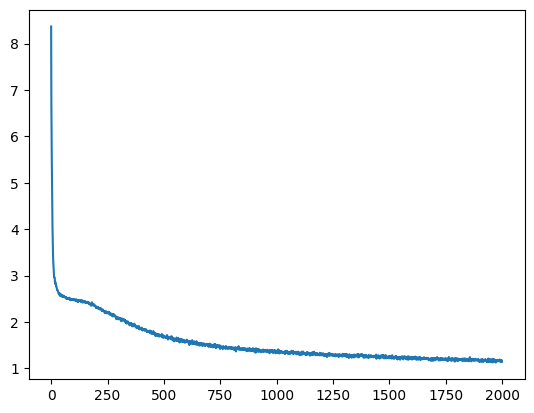

In [18]:
print('Val Loss is: ', calc_loss(test_data, model, 5, device))
plt.plot(torch.tensor(train_loss).cpu().numpy())
plt.show()

In [19]:
print(model.generate_token(torch.zeros((1, 1), dtype=torch.long, device=device), 1000))



Secure, thou hast done with the honour of the goss
stren. How! Montague forgive those this
forth, I should ask,
any let thee weed, and of Rome, and this wing
membring thy happy instructs. But, if we have
did so offender; and make ease of love time
own full days of letters. But, and the news cape,
As each of faults of holy vict:
The birthless wheels the was a Crosby, it wass for
two sented in his heir, and man hateful is
that would have?

PAULINA:
Indeed;
Both and and dear days of saying fineess,
To make thee larged-head; no liver from and die:
It should be the little lives our head;
And made me my pleasure of Rome,
'Tis blind to us; Is fall in forfeit
With one hundred looks the welewise lie!
Ha! wondon he censure, who shoes wanders
Made for adversared, for his brother had brought:
We have some vantage: who cames
Mine own of griefect was done to roan?

ANTIGONUS:
Ay, by her careless of me, gains-wife,
And from flowers and Jerkius, to go:
Be rply, my liege,
Be in the looking of my brai

In [20]:
!cp /content/checkpoint.pth /content/drive/MyDrive/LLM